In [34]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

from scipy.stats import linregress
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, message="The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.")

# %%
def load_data(ticker='SPY', start='2008-01-01', end=None):
    """
    Load historical data for a given ticker using yfinance.
    """
    if end is None:
        end = datetime.now().strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start, end=end)
    return df

def extract_monthly_data(seasonality_table, month):
    """
    Extract data for a specific month.
    """
    return seasonality_table.loc[month]

def visualize_monthly_data(monthly_data, month):
    """
    Visualize the extracted data for the selected month.
    """
    plt.figure(figsize=(10, 6))
    plt.bar(monthly_data.index, monthly_data.values, color='dodgerblue')
    plt.xlabel('Year')
    plt.ylabel(f'Average {month} Return (%)')
    plt.title(f'Average {month} Returns Over the Years')
    plt.xticks(rotation=45)
    plt.show()

def perform_quantitative_analysis(monthly_data, month):
    """
    Perform quantitative analysis on the extracted monthly data.
    """
    mean_return = monthly_data.mean()
    std_return = monthly_data.std()
    highest_return_year = monthly_data.idxmax()
    highest_return_value = monthly_data.max()
    lowest_return_year = monthly_data.idxmin()
    lowest_return_value = monthly_data.min()

    print(f"Mean {month} Return: {mean_return:.2f}%")
    print(f"Standard Deviation of {month} Returns: {std_return:.2f}%")
    print(f"Highest {month} Return: {highest_return_value:.2f}% in {highest_return_year}")
    print(f"Lowest {month} Return: {lowest_return_value:.2f}% in {lowest_return_year}")

    # Determine Overall Trend
    years = monthly_data.index.astype(int)
    returns = monthly_data.values
    if len(set(returns)) > 1:  # Check for variance in data
        slope, intercept, r_value, p_value, std_err = linregress(years, returns)

        plt.figure(figsize=(10, 6))
        plt.bar(monthly_data.index, monthly_data.values, color='dodgerblue', label=f'{month} Return')
        plt.plot(monthly_data.index, intercept + slope*years, 'r', label=f'Trend Line (slope={slope:.2f})')
        plt.xlabel('Year')
        plt.ylabel(f'Average {month} Return (%)')
        plt.title(f'Average {month} Returns Over the Years with Trend Line')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

        print(f"Trend Line Slope: {slope:.2f}% per year")
        print(f"R-squared: {r_value**2:.2f}")
    else:
        print(f"No variance in {month} data to compute trend line.")

def calculate_technical_indicators(df):
    """
    Calculate RSI, Bollinger Bands, and MACD for the given dataframe.
    """
    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # Calculate Bollinger Bands
    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)

    # Calculate MACD
    df['12 EMA'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['26 EMA'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12 EMA'] - df['26 EMA']
    df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    print("Technical Indicators:\n", df[['RSI', 'Upper Band', 'Lower Band', 'MACD', 'Signal Line']].head())
    return df

def plot_monthly_technical_indicators(df):
    """
    Plot RSI, Bollinger Bands, and MACD for the given dataframe.
    """
    plt.figure(figsize=(14, 10))

    # Plot Close Price and Bollinger Bands
    plt.subplot(4, 1, 1)
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
    plt.plot(df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
    plt.fill_between(df.index, df['Upper Band'], df['Lower Band'], alpha=0.1)
    plt.title('Monthly Close Price and Bollinger Bands')
    plt.legend()

    # Plot RSI
    plt.subplot(4, 1, 2)
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='r')
    plt.axhline(30, linestyle='--', alpha=0.5, color='g')
    plt.title('Monthly Relative Strength Index (RSI)')
    plt.legend()

    # Plot MACD
    plt.subplot(4, 1, 3)
    plt.plot(df['MACD'], label='MACD', color='g')
    plt.plot(df['Signal Line'], label='Signal Line', color='orange')
    plt.fill_between(df.index, df['MACD'] - df['Signal Line'], 0, alpha=0.2, color='grey')
    plt.title('Monthly MACD and Signal Line')
    plt.legend()

    plt.tight_layout()
    plt.show()

def fetch_fed_data(series, start_date='2008-01-01'):
    """
    Fetch macroeconomic data from FRED.
    """
    return pdr.get_data_fred(series, start=start_date)

def merge_macro_data(financial_df, macro_df):
    """
    Merge financial data with macroeconomic data.
    """
    macro_df = macro_df.resample('M').ffill()  # Ensure macro data is also monthly
    merged_df = financial_df.merge(macro_df, left_index=True, right_index=True, how='inner')
    print("Merged Data:\n", merged_df.head())
    return merged_df

def plot_with_macro_data(merged_df):
    """
    Plot financial indicators with macroeconomic data.
    """
    fig, axs = plt.subplots(4, 1, figsize=(14, 12))

    # Plot Close Price and Bollinger Bands
    axs[0].plot(merged_df['Close'], label='Close Price')
    axs[0].plot(merged_df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
    axs[0].plot(merged_df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
    axs[0].fill_between(merged_df.index, merged_df['Upper Band'], merged_df['Lower Band'], alpha=0.1)
    axs[0].set_title('Monthly Close Price and Bollinger Bands')
    axs[0].legend()

    # Plot RSI
    axs[1].plot(merged_df['RSI'], label='RSI', color='purple')
    axs[1].axhline(70, linestyle='--', alpha=0.5, color='r')
    axs[1].axhline(30, linestyle='--', alpha=0.5, color='g')
    axs[1].set_title('Monthly Relative Strength Index (RSI)')
    axs[1].legend()

    # Plot MACD
    axs[2].plot(merged_df['MACD'], label='MACD', color='g')
    axs[2].plot(merged_df['Signal Line'], label='Signal Line', color='orange')
    axs[2].fill_between(merged_df.index, merged_df['MACD'] - merged_df['Signal Line'], 0, alpha=0.2, color='grey')
    axs[2].set_title('Monthly MACD and Signal Line')
    axs[2].legend()

    # Plot Fed Funds Rate
    axs[3].plot(merged_df['FEDFUNDS'], label='Federal Funds Rate', color='blue')
    axs[3].set_title('Federal Funds Rate')
    axs[3].legend()

    plt.tight_layout()
    plt.show()

# Define the half-Kelly criterion function
def half_kelly_criterion(mean_return, std_return):
    win_prob = (mean_return / std_return) ** 2 / ((mean_return / std_return) ** 2 + 1)
    loss_prob = 1 - win_prob
    odds = mean_return / std_return
    kelly_fraction = (win_prob - loss_prob) / odds
    half_kelly_fraction = kelly_fraction / 2
    return half_kelly_fraction

# Define portfolio return and variance calculations
def calculate_portfolio_return(weights, returns):
    return np.dot(weights, returns)

def calculate_portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Objective function to maximize portfolio return
def objective_function(weights):
    portfolio_return = calculate_portfolio_return(weights, returns)
    portfolio_variance = calculate_portfolio_variance(weights, cov_matrix)
    portfolio_std_dev = np.sqrt(portfolio_variance)
    return -portfolio_return  # Negative for minimization

def apply_kelly_method(mean_return, std_dev, win_prob):
    """Calculate the Kelly criterion for position sizing."""
    b = mean_return / std_dev  # Assuming b is the edge ratio
    kelly_fraction = win_prob - ((1 - win_prob) / b)
    return kelly_fraction

def machine_learning_analysis(df):
    """Perform machine learning analysis using RandomForest and return the model and accuracy."""
    df['Target'] = (df['Return'] > 0).astype(int)  # Binary classification: 1 if return is positive, 0 otherwise
    features = ['Adj Close', 'Return']  # Example features; you can add more technical indicators
    X = df[features].shift(1)  # Shift features to avoid look-ahead bias
    y = df['Target'].shift(1)
    # Drop rows with NaN values to ensure consistent lengths
    X, y = X.dropna(), y.dropna()
    X, y = X.align(y, join='inner', axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.2f}")
    return model, accuracy

def create_summary_csv(tickers, start_date, end_date, filename='summary.csv'):
    """Create a CSV file with mean, std, count, positive_prob, and Kelly size for all assets."""
    summary_data = []
    for ticker in tickers:
        df = load_price_data(ticker, start=start_date, end=end_date)
        if isinstance(df, pd.Series):
            df = df.to_frame(name='Adj Close')
        if 'Adj Close' not in df.columns:
            print(f"Column 'Adj Close' not found in the data for {ticker}. Available columns: {df.columns}")
            continue
        df = calculate_returns(df)
        seasonality_table = create_seasonality_table(df)
        for month, stats in seasonality_table.iterrows():
            mean_return = stats['mean']
            std_dev = stats['std']
            count = stats['count']
            positive_prob = stats['positive_prob']
            kelly_size = apply_kelly_method(mean_return, std_dev, positive_prob)
            summary_data.append({
                'Ticker': ticker,
                'Month': month,
                'Mean Return': mean_return,
                'Standard Deviation': std_dev,
                'Count': count,
                'Positive Probability': positive_prob,
                'Kelly Size': kelly_size
            })
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(filename, index=False)
    print(f"Summary CSV created: {filename}")

def analyze_ticker(ticker, start_date, end_date):
    df = load_price_data(ticker, start=start_date, end=end_date)
    if isinstance(df, pd.Series):
        df = df.to_frame(name='Adj Close')
    if 'Adj Close' not in df.columns:
        print(f"Column 'Adj Close' not found in the data for {ticker}. Available columns: {df.columns}")
        return
    df = calculate_returns(df)
    seasonality_table = create_seasonality_table(df)
    visualize_seasonality_table(seasonality_table, f'Seasonality of {ticker} Returns')
    display_all_monthly_statistics_with_kelly(df)
    # Machine Learning Analysis
    model, accuracy = machine_learning_analysis(df)

def seasonality_analysis(df):
    """Perform seasonality analysis."""
    return df.groupby(df.index.month)['Monthly Return'].agg(['mean', 'std', 'count', 'positive_prob'])

def plot_technical_indicators(df):
    """
    Plot RSI, Bollinger Bands, and MACD for the given dataframe.
    """
    plt.figure(figsize=(14, 10))

    # Plot Close Price and Bollinger Bands
    plt.subplot(3, 1, 1)
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
    plt.plot(df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
    plt.fill_between(df.index, df['Upper Band'], df['Lower Band'], alpha=0.1)
    plt.title('Close Price and Bollinger Bands')
    plt.legend()

    # Plot RSI
    plt.subplot(3, 1, 2)
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='r')
    plt.axhline(30, linestyle='--', alpha=0.5, color='g')
    plt.title('Relative Strength Index (RSI)')
    plt.legend()

    # Plot MACD
    plt.subplot(3, 1, 3)
    plt.plot(df['MACD'], label='MACD', color='g')
    plt.plot(df['Signal Line'], label='Signal Line', color='orange')
    plt.fill_between(df.index, df['MACD'] - df['Signal Line'], 0, alpha=0.2, color='grey')
    plt.title('MACD and Signal Line')
    plt.legend()

    plt.tight_layout()

def calculate_returns(df, period='ME'):
    """
    Calculate percentage returns based on the specified period.
    """
    df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
    df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
    return df

def create_seasonality_table(df, column='Return'):
    """
    Create a pivot table for seasonality analysis.
    """
    seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month, aggfunc=np.mean)
    # Ensure all months are represented
    seasonality_table = seasonality_table.reindex(columns=range(1, 13))
    seasonality_table.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    seasonality_table = seasonality_table.transpose()
    return seasonality_table

def visualize_seasonality_table(seasonality_table, ticker):
    """
    Visualize the seasonality table using a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(seasonality_table, annot=True, fmt=".2f", cmap='RdYlGn', center=0)
    plt.title(f'Seasonality of {ticker} Returns')
    plt.show()

def display_all_monthly_statistics(seasonality_table, seasonality_volume_table, ticker):
    """
    Display the statistics for each month in the seasonality table.
    """
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for month in months:
        monthly_data = seasonality_table.loc[month]
        monthly_volume = seasonality_volume_table.loc[month]
        mean_return = monthly_data.mean()
        std_return = monthly_data.std()
        highest_return_year = monthly_data.idxmax()
        highest_return_value = monthly_data.max()
        lowest_return_year = monthly_data.idxmin()
        lowest_return_value = monthly_data.min()
        mean_volume = monthly_volume.mean()
        highest_volume_year = monthly_volume.idxmax()
        highest_volume_value = monthly_volume.max()
        lowest_volume_year = monthly_volume.idxmin()
        lowest_volume_value = monthly_volume.min()

        print(f"{ticker} - {month} Statistics")
        print(f"Mean {month} Return: {mean_return:.2f}%")
        print(f"Standard Deviation of {month} Returns: {std_return:.2f}%")
        print(f"Highest {month} Return: {highest_return_value:.2f}% in {highest_return_year}")
        print(f"Lowest {month} Return: {lowest_return_value:.2f}% in {lowest_return_year}")
        print(f"Mean {month} Volume: {mean_volume:.2f}")
        print(f"Highest {month} Volume: {highest_volume_value:.2f} in {highest_volume_year}")
        print(f"Lowest {month} Volume: {lowest_volume_value:.2f} in {lowest_volume_year}")
        print()


In [35]:
# from data_collection.data_processing import load_data

# from data_processing import load_data
# from data_seasonality import calculate_returns, create_seasonality_table, visualize_seasonality_table
# from data_visualization import calculate_technical_indicators, plot_monthly_technical_indicators


[*********************100%%**********************]  1 of 1 completed

Processing data for NVDA...



C:\Users\Administrator\AppData\Local\Temp\ipykernel_30968\1616914173.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_30968\1616914173.py:328: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
C:\Users\Administrator\AppData\Local\Temp\ipykernel_30968\1616914173.py:335: FutureWarning: The provided callable <function mean at 0x0000020CDF83AB60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month, aggfunc=np.mean)
C:\Users\Administrator\AppData\Local\Temp\ipykerne

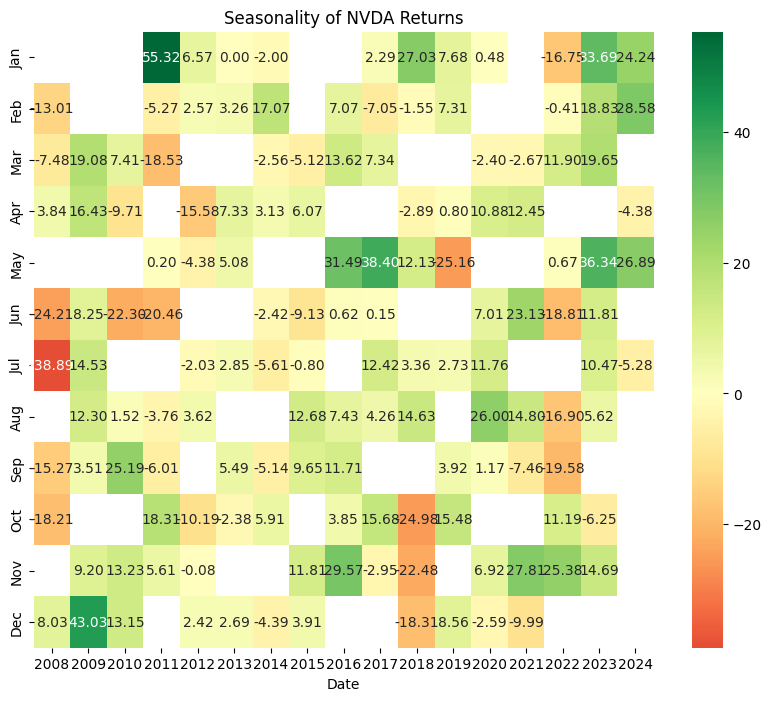

[*********************100%%**********************]  1 of 1 completed

NVDA - Jan Statistics
Mean Jan Return: 12.60%
Standard Deviation of Jan Returns: 20.40%
Highest Jan Return: 55.32% in 2011
Lowest Jan Return: -16.75% in 2022
Mean Jan Volume: 12677105750.00
Highest Jan Volume: 32736884000.00 in 2011
Lowest Jan Volume: 5421052000.00 in 2014

NVDA - Feb Statistics
Mean Feb Return: 4.78%
Standard Deviation of Feb Returns: 11.90%
Highest Feb Return: 28.58% in 2024
Lowest Feb Return: -13.01% in 2008
Mean Feb Volume: 12503516000.00
Highest Feb Volume: 24025764000.00 in 2011
Lowest Feb Volume: 7722568000.00 in 2014

NVDA - Mar Statistics
Mean Mar Return: 3.35%
Standard Deviation of Mar Returns: 11.66%
Highest Mar Return: 19.65% in 2023
Lowest Mar Return: -18.53% in 2011
Mean Mar Volume: 13266347500.00
Highest Mar Volume: 27597580000.00 in 2011
Lowest Mar Volume: 6577904000.00 in 2016

NVDA - Apr Statistics
Mean Apr Return: 2.36%
Standard Deviation of Apr Returns: 9.33%
Highest Apr Return: 16.43% in 2009
Lowest Apr Return: -15.58% in 2012
Mean Apr Volume: 1096


C:\Users\Administrator\AppData\Local\Temp\ipykernel_30968\1616914173.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_30968\1616914173.py:328: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
C:\Users\Administrator\AppData\Local\Temp\ipykernel_30968\1616914173.py:335: FutureWarning: The provided callable <function mean at 0x0000020CDF83AB60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month, aggfunc=np.mean)
C:\Users\Administrator\AppData\Local\Temp\ipykerne

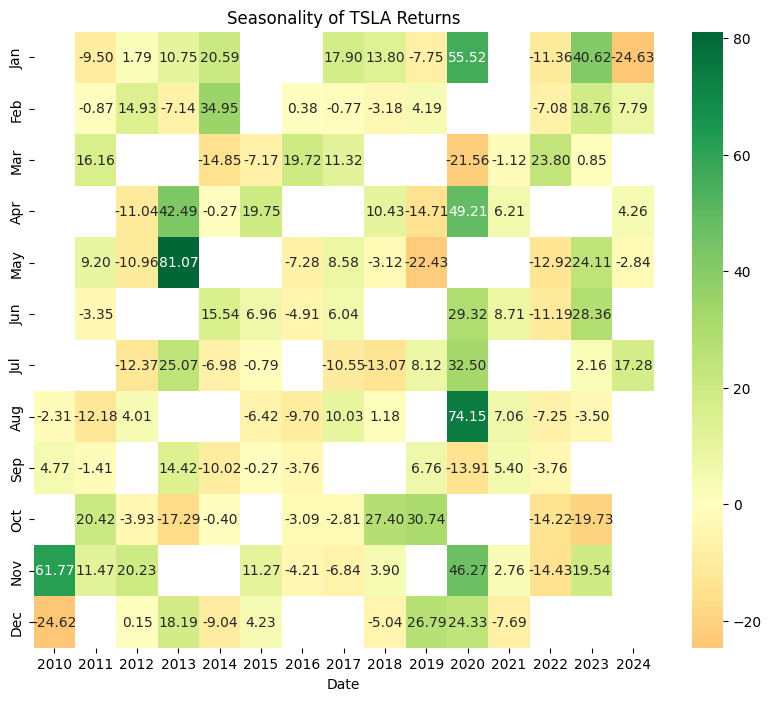

[*********************100%%**********************]  1 of 1 completed

TSLA - Jan Statistics
Mean Jan Return: 9.79%
Standard Deviation of Jan Returns: 23.70%
Highest Jan Return: 55.52% in 2020
Lowest Jan Return: -24.63% in 2024
Mean Jan Volume: 2206456309.09
Highest Jan Volume: 6108277500.00 in 2020
Lowest Jan Volume: 384148500.00 in 2012

TSLA - Feb Statistics
Mean Feb Return: 5.63%
Standard Deviation of Feb Returns: 12.80%
Highest Feb Return: 34.95% in 2014
Lowest Feb Return: -7.14% in 2013
Mean Feb Volume: 1749206909.09
Highest Feb Volume: 3624845100.00 in 2023
Lowest Feb Volume: 347904000.00 in 2012

TSLA - Mar Statistics
Mean Mar Return: 3.02%
Standard Deviation of Mar Returns: 15.82%
Highest Mar Return: 23.80% in 2022
Lowest Mar Return: -21.56% in 2020
Mean Mar Volume: 2462802166.67
Highest Mar Volume: 6314025000.00 in 2020
Lowest Mar Volume: 488449500.00 in 2011

TSLA - Apr Statistics
Mean Apr Return: 11.82%
Standard Deviation of Apr Returns: 21.98%
Highest Apr Return: 49.21% in 2020
Lowest Apr Return: -14.71% in 2019
Mean Apr Volume: 2453222488.89


C:\Users\Administrator\AppData\Local\Temp\ipykernel_30968\1616914173.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_30968\1616914173.py:328: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
C:\Users\Administrator\AppData\Local\Temp\ipykernel_30968\1616914173.py:335: FutureWarning: The provided callable <function mean at 0x0000020CDF83AB60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month, aggfunc=np.mean)
C:\Users\Administrator\AppData\Local\Temp\ipykerne

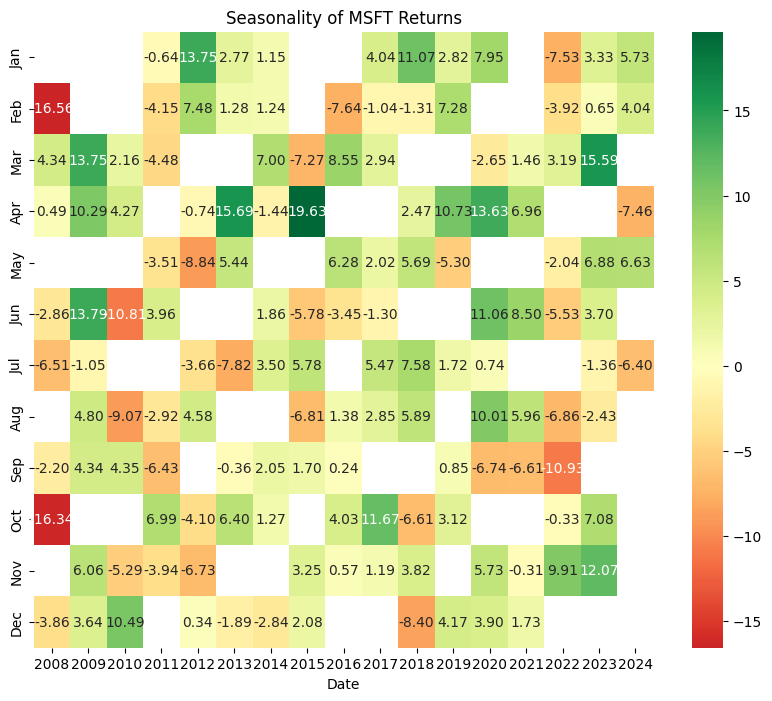

[*********************100%%**********************]  1 of 1 completed

MSFT - Jan Statistics
Mean Jan Return: 4.04%
Standard Deviation of Jan Returns: 5.74%
Highest Jan Return: 13.75% in 2012
Lowest Jan Return: -7.53% in 2022
Mean Jan Volume: 935354350.00
Highest Jan Volume: 1950301600.00 in 2008
Lowest Jan Volume: 493453500.00 in 2017

MSFT - Feb Statistics
Mean Feb Return: -1.05%
Standard Deviation of Feb Returns: 6.63%
Highest Feb Return: 7.48% in 2012
Lowest Feb Return: -16.56% in 2008
Mean Feb Volume: 843014591.67
Highest Feb Volume: 2324580800.00 in 2008
Lowest Feb Volume: 440744000.00 in 2017

MSFT - Mar Statistics
Mean Mar Return: 3.71%
Standard Deviation of Mar Returns: 6.83%
Highest Mar Return: 15.59% in 2023
Lowest Mar Return: -7.27% in 2015
Mean Mar Volume: 1004326458.33
Highest Mar Volume: 1625752800.00 in 2009
Lowest Mar Volume: 489169700.00 in 2017

MSFT - Apr Statistics
Mean Apr Return: 6.21%
Standard Deviation of Apr Returns: 8.02%
Highest Apr Return: 19.63% in 2015
Lowest Apr Return: -7.46% in 2024
Mean Apr Volume: 954060633.33
Highest A


C:\Users\Administrator\AppData\Local\Temp\ipykernel_30968\1616914173.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
C:\Users\Administrator\AppData\Local\Temp\ipykernel_30968\1616914173.py:328: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Volume'] = df['Volume'].resample(period).sum()  # Sum volume for each period
C:\Users\Administrator\AppData\Local\Temp\ipykernel_30968\1616914173.py:335: FutureWarning: The provided callable <function mean at 0x0000020CDF83AB60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  seasonality_table = df.pivot_table(values=column, index=df.index.year, columns=df.index.month, aggfunc=np.mean)
C:\Users\Administrator\AppData\Local\Temp\ipykerne

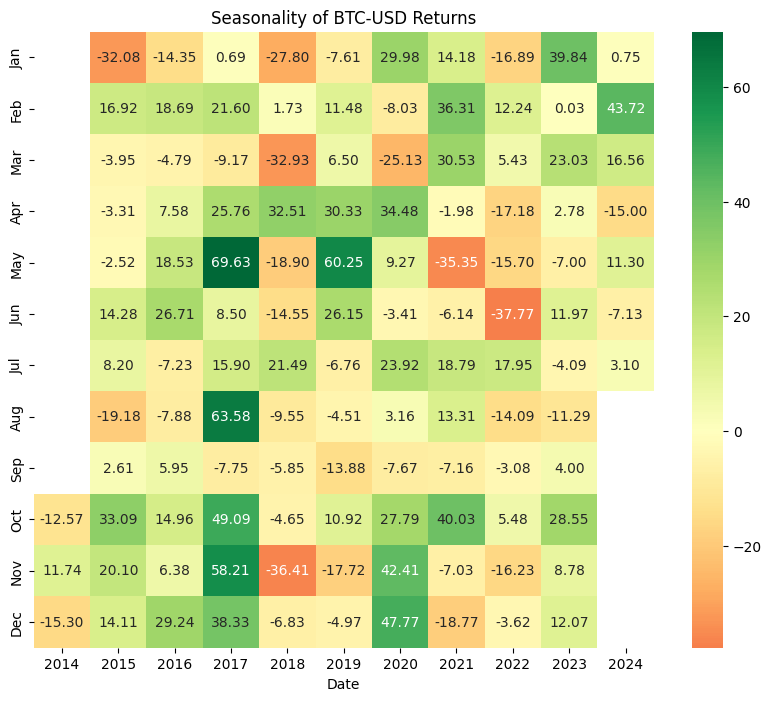

BTC-USD - Jan Statistics
Mean Jan Return: -1.33%
Standard Deviation of Jan Returns: 23.62%
Highest Jan Return: 39.84% in 2023
Lowest Jan Return: -32.08% in 2015
Mean Jan Volume: 603905483408.80
Highest Jan Volume: 2153473433571.00 in 2021
Lowest Jan Volume: 1098811912.00 in 2015

BTC-USD - Feb Statistics
Mean Feb Return: 15.47%
Standard Deviation of Feb Returns: 15.94%
Highest Feb Return: 43.72% in 2024
Lowest Feb Return: -8.03% in 2020
Mean Feb Volume: 609224483495.50
Highest Feb Volume: 2267152936675.00 in 2021
Lowest Feb Volume: 711518700.00 in 2015

BTC-USD - Mar Statistics
Mean Mar Return: 0.61%
Standard Deviation of Mar Returns: 20.12%
Highest Mar Return: 30.53% in 2021
Lowest Mar Return: -32.93% in 2018
Mean Mar Volume: 663815661780.80
Highest Mar Volume: 1681184264687.00 in 2021
Lowest Mar Volume: 959098300.00 in 2015

BTC-USD - Apr Statistics
Mean Apr Return: 9.60%
Standard Deviation of Apr Returns: 19.74%
Highest Apr Return: 34.48% in 2020
Lowest Apr Return: -17.18% in 2022
M

In [36]:


# Main execution for multiple tickers
# tickers = ['SPY', 'QQQ', 'DOW', 'SPYD', 'O', 'AGNC', 'TQQQ', 'SQQQ', 'SPXS', 'NVDL', 'TSLL', 'MSFT', 'BITO']
tickers = [ 'NVDA', 'TSLA', 'MSFT', 'BTC-USD']
for ticker in tickers:
    print(f"Processing data for {ticker}...")
    df = load_data(ticker)
    df = calculate_returns(df, period='M')
    seasonality_table = create_seasonality_table(df, column='Return')
    seasonality_volume_table = create_seasonality_table(df, column='Volume')
    visualize_seasonality_table(seasonality_table, ticker)
    display_all_monthly_statistics(seasonality_table, seasonality_volume_table, ticker)


In [37]:


def main():
    # Load SPY data
    ticker = 'SPY'
    start_date = '2008-01-01'
    df = load_data(ticker, start=start_date)
    
    # Resample to monthly frequency
    df_monthly = resample_monthly(df)
    
    # Calculate technical indicators
    df_monthly = calculate_technical_indicators(df_monthly)
    
    # Fetch Fed data
    fed_funds = fetch_fed_data('FEDFUNDS', start_date=start_date)
    
    # Merge financial data with macroeconomic data
    merged_df = merge_macro_data(df_monthly, fed_funds)
    
    # Plot the combined data
    plot_with_macro_data(merged_df)

if __name__ == "__main__":
    main()


[*********************100%%**********************]  1 of 1 completed


NameError: name 'resample_monthly' is not defined

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import yfinance as yf
# from datetime import datetime

def calculate_technical_indicators(df):
    # Calculate ATR
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.rolling(window=14).mean()
    
    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))
    
    # Calculate Bollinger Bands
    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    
    # Calculate Ichimoku Cloud
    high_9 = df['High'].rolling(window=9).max()
    low_9 = df['Low'].rolling(window=9).min()
    df['tenkan_sen'] = (high_9 + low_9) / 2

    high_26 = df['High'].rolling(window=26).max()
    low_26 = df['Low'].rolling(window=26).min()
    df['kijun_sen'] = (high_26 + low_26) / 2

    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)
    high_52 = df['High'].rolling(window=52).max()
    low_52 = df['Low'].rolling(window=52).min()
    df['senkou_span_b'] = ((high_52 + low_52) / 2).shift(26)

    df['chikou_span'] = df['Close'].shift(-26)
    
    return df

def display_all_monthly_statistics(df, ticker):
    df = calculate_technical_indicators(df)
    
    # Resample data to monthly
    df_monthly = df.resample('M').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',
        'ATR': 'mean',
        'RSI': 'mean',
        '20 Day MA': 'mean',
        'Upper Band': 'mean',
        'Lower Band': 'mean',
        'tenkan_sen': 'mean',
        'kijun_sen': 'mean',
        'senkou_span_a': 'mean',
        'senkou_span_b': 'mean',
        'chikou_span': 'mean'
    })
    
    df_monthly['Return'] = df_monthly['Close'].pct_change() * 100
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for month in range(1, 13):
        monthly_data = df_monthly[df_monthly.index.month == month]
        if monthly_data.empty:
            continue
        mean_return = monthly_data['Return'].mean()
        std_return = monthly_data['Return'].std()
        highest_return_year = monthly_data['Return'].idxmax().year
        highest_return_value = monthly_data['Return'].max()
        lowest_return_year = monthly_data['Return'].idxmin().year
        lowest_return_value = monthly_data['Return'].min()
        mean_volume = monthly_data['Volume'].mean()
        highest_volume_year = monthly_data['Volume'].idxmax().year
        highest_volume_value = monthly_data['Volume'].max()
        lowest_volume_year = monthly_data['Volume'].idxmin().year
        lowest_volume_value = monthly_data['Volume'].min()

        print(f"{ticker} - {months[month-1]} Statistics")
        print(f"Mean {months[month-1]} Return: {mean_return:.2f}%")
        print(f"Standard Deviation of {months[month-1]} Returns: {std_return:.2f}%")
        print(f"Highest {months[month-1]} Return: {highest_return_value:.2f}% in {highest_return_year}")
        print(f"Lowest {months[month-1]} Return: {lowest_return_value:.2f}% in {lowest_return_year}")
        print(f"Mean {months[month-1]} Volume: {mean_volume:.2f}")
        print(f"Highest {months[month-1]} Volume: {highest_volume_value:.2f} in {highest_volume_year}")
        print(f"Lowest {months[month-1]} Volume: {lowest_volume_value:.2f} in {lowest_volume_year}")
        print(f"Mean {months[month-1]} ATR: {monthly_data['ATR'].mean():.2f}")
        print(f"Mean {months[month-1]} RSI: {monthly_data['RSI'].mean():.2f}")
        print(f"Mean {months[month-1]} 20 Day MA: {monthly_data['20 Day MA'].mean():.2f}")
        print(f"Mean {months[month-1]} Upper Band: {monthly_data['Upper Band'].mean():.2f}")
        print(f"Mean {months[month-1]} Lower Band: {monthly_data['Lower Band'].mean():.2f}")
        print(f"Mean {months[month-1]} Tenkan-sen: {monthly_data['tenkan_sen'].mean():.2f}")
        print(f"Mean {months[month-1]} Kijun-sen: {monthly_data['kijun_sen'].mean():.2f}")
        print(f"Mean {months[month-1]} Senkou Span A: {monthly_data['senkou_span_a'].mean():.2f}")
        print(f"Mean {months[month-1]} Senkou Span B: {monthly_data['senkou_span_b'].mean():.2f}")
        print(f"Mean {months[month-1]} Chikou Span: {monthly_data['chikou_span'].mean():.2f}")

        # Add checks for conditions
        close_greater_than_rsi = (monthly_data['Close'] > monthly_data['RSI']).sum()
        close_greater_than_upper_band = (monthly_data['Close'] > monthly_data['Upper Band']).sum()
        high_greater_than_atr = (monthly_data['High'] > monthly_data['ATR']).sum()

        print(f"Number of days Close > RSI in {months[month-1]}: {close_greater_than_rsi}")
        print(f"Number of days Close > Upper Bollinger Band in {months[month-1]}: {close_greater_than_upper_band}")
        print(f"Number of days High > ATR in {months[month-1]}: {high_greater_than_atr}")
        print()


df = load_data('SPY')
display_all_monthly_statistics(df, 'SPY')


In [ ]:

# Load historical SPY data
spy_data = yf.download('SPY', start='2000-01-01', end='2023-12-31')

# Resample to monthly data
spy_data['Return'] = spy_data['Adj Close'].pct_change()
spy_data['Month'] = spy_data.index.month
spy_data['Year'] = spy_data.index.year
spy_data_monthly = spy_data.resample('M').apply({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Adj Close': 'last',
    'Volume': 'sum',
    'Return': 'sum'
})



spy_data = calculate_technical_indicators(spy_data)

# Define the strategy
def apply_strategy(df):
    initial_capital = 100000  # Starting with $100,000
    capital = initial_capital
    position = 0  # No initial position
    returns = []

    for i in range(1, len(df)):
        month = df.index[i].month
        if month in [4, 7, 11]:  # Buy in April, July, and November
            if position == 0:
                position = capital / df['Adj Close'].iloc[i]
                capital = 0
        elif month in [6, 8, 9]:  # Sell in June, August, and September
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
        else:  # Hedge or hold
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
            position = capital / df['Adj Close'].iloc[i]
            capital = 0
        
        # Calculate monthly return
        total_value = capital + position * df['Adj Close'].iloc[i]
        monthly_return = (total_value - initial_capital) / initial_capital
        returns.append(monthly_return)

    # Final capital
    if position > 0:
        capital = position * df['Adj Close'].iloc[-1]

    return returns, capital

# Backtest the strategy
monthly_returns, final_capital = apply_strategy(spy_data_monthly)

# Calculate performance metrics
cumulative_returns = (1 + np.array(monthly_returns)).cumprod()
total_return = (final_capital - 100000) / 100000
annualized_return = np.mean(monthly_returns) * 12
annualized_volatility = np.std(monthly_returns) * np.sqrt(12)
sharpe_ratio = annualized_return / annualized_volatility

# Print performance metrics
print(f"Final Portfolio Value: ${final_capital:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Ensure x and y have the same length
spy_data_monthly = spy_data_monthly.iloc[1:]  # Exclude the first month for alignment

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(spy_data_monthly.index, cumulative_returns, label='Strategy')
plt.plot(spy_data_monthly.index, (spy_data_monthly['Adj Close'] / spy_data_monthly['Adj Close'].iloc[0]), label='SPY')
plt.title('Strategy vs SPY Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Load historical SPY data
spy_data = yf.download('SPY', start='2000-01-01', end='2023-12-31')

# Resample to monthly data
spy_data['Return'] = spy_data['Adj Close'].pct_change()
spy_data['Month'] = spy_data.index.month
spy_data['Year'] = spy_data.index.year
spy_data_monthly = spy_data.resample('M').apply({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Adj Close': 'last',
    'Volume': 'sum',
    'Return': 'sum'
})



spy_data = calculate_technical_indicators(spy_data)

# Define the strategy
def apply_strategy(df):
    initial_capital = 5000  # Starting with $5,000
    capital = initial_capital
    position = 0  # No initial position
    returns = []

    for i in range(1, len(df)):
        month = df.index[i].month
        if month in [4, 7, 11]:  # Buy in April, July, and November
            if position == 0:
                position = capital / df['Adj Close'].iloc[i]
                capital = 0
        elif month in [6, 8, 9]:  # Sell in June, August, and September
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
        else:  # Hedge or hold
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
            position = capital / df['Adj Close'].iloc[i]
            capital = 0
        
        # Calculate monthly return
        total_value = capital + position * df['Adj Close'].iloc[i]
        monthly_return = (total_value - initial_capital) / initial_capital
        returns.append(monthly_return)

    # Final capital
    if position > 0:
        capital = position * df['Adj Close'].iloc[-1]

    return returns, capital

# Backtest the strategy
monthly_returns, final_capital = apply_strategy(spy_data_monthly)

# Calculate performance metrics
cumulative_returns = (1 + np.array(monthly_returns)).cumprod()
total_return = (final_capital - 5000) / 5000
annualized_return = np.mean(monthly_returns) * 12
annualized_volatility = np.std(monthly_returns) * np.sqrt(12)
sharpe_ratio = annualized_return / annualized_volatility

# Print performance metrics
print(f"Final Portfolio Value: ${final_capital:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Ensure x and y have the same length
spy_data_monthly = spy_data_monthly.iloc[1:]  # Exclude the first month for alignment

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(spy_data_monthly.index, cumulative_returns, label='Strategy')
plt.plot(spy_data_monthly.index, (spy_data_monthly['Adj Close'] / spy_data_monthly['Adj Close'].iloc[0]), label='SPY')
plt.title('Strategy vs SPY Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:


def create_summary_csv(tickers, start_date, end_date, filename='summary.csv'):
    """Create a CSV file with mean, std, count, positive_prob, and Kelly size for all assets."""
    summary_data = []
    for ticker in tickers:
        df = load_price_data(ticker, start=start_date, end=end_date)
        if isinstance(df, pd.Series):
            df = df.to_frame(name='Adj Close')
        if 'Adj Close' not in df.columns:
            print(f"Column 'Adj Close' not found in the data for {ticker}. Available columns: {df.columns}")
            continue
        df = calculate_returns(df)
        seasonality_table = create_seasonality_table(df)
        for month, stats in seasonality_table.iterrows():
            mean_return = stats['mean']
            std_dev = stats['std']
            count = stats['count']
            positive_prob = stats['positive_prob']
            kelly_size = apply_kelly_method(mean_return, std_dev, positive_prob)
            summary_data.append({
                'Ticker': ticker,
                'Month': month,
                'Mean Return': mean_return,
                'Standard Deviation': std_dev,
                'Count': count,
                'Positive Probability': positive_prob,
                'Kelly Size': kelly_size
            })
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(filename, index=False)
    print(f"Summary CSV created: {filename}")

def analyze_ticker(ticker, start_date, end_date):
    df = load_price_data(ticker, start=start_date, end=end_date)
    if isinstance(df, pd.Series):
        df = df.to_frame(name='Adj Close')
    if 'Adj Close' not in df.columns:
        print(f"Column 'Adj Close' not found in the data for {ticker}. Available columns: {df.columns}")
        return
    df = calculate_returns(df)
    seasonality_table = create_seasonality_table(df)
    visualize_seasonality_table(seasonality_table, f'Seasonality of {ticker} Returns')
    display_all_monthly_statistics_with_kelly(df)
    # Machine Learning Analysis
    model, accuracy = machine_learning_analysis(df)


# 52 Week Seasonality with Kelly Method

In [ ]:
def visualize_weekly_seasonality(tickers, start_date, end_date, triple_witching_weeks):
    """
    Visualizes the 52-week seasonality of a list of tickers.

    Parameters:
    tickers (list): List of ticker symbols to analyze.
    start_date (str): Start date for the historical data in "YYYY-MM-DD" format.
    end_date (str): End date for the historical data in "YYYY-MM-DD" format.
    triple_witching_weeks (list): List of week numbers that represent triple witching weeks.
    """
    
    # Download historical data for all tickers
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

    for ticker in tickers:
        # Calculate weekly returns and volume statistics
        df = data[ticker].copy()
        df['Return'] = df['Adj Close'].pct_change()
        df['Week_Number'] = df.index.isocalendar().week
        df['Year'] = df.index.year
        df['Ticker'] = ticker

        # Group data by year and week number
        weekly_data = df.groupby(['Year', 'Week_Number']).agg({
            'Return': 'sum',
            'Volume': 'mean'
        }).reset_index()
        weekly_data['Week'] = weekly_data['Week_Number'].astype(int)

        # Pivot the data for heatmap creation
        pivot_data = weekly_data.pivot(index="Week", columns="Year", values="Return")

        # Plot the heatmap with enhanced contrast and triple witching weeks highlighted
        plt.figure(figsize=(14, 8))
        sns.heatmap(pivot_data, annot=False, fmt=".2f", cmap="coolwarm", center=0, linewidths=.5, 
                    cbar_kws={'label': 'Weekly Return'})

        # Highlight Triple Witching Weeks
        for week in triple_witching_weeks:
            plt.axhline(y=week-0.5, color='yellow', linewidth=2)

        plt.title(f'Seasonality of {ticker} Returns')
        plt.show()


In [ ]:
def export_weekly_seasonality_data(tickers, start_date, end_date, odds_ratio=2, output_dir='seasonality_data'):
    """
    Exports the 52-week seasonality data of a list of tickers to CSV files.

    Parameters:
    tickers (list): List of ticker symbols to analyze.
    start_date (str): Start date for the historical data in "YYYY-MM-DD" format.
    end_date (str): End date for the historical data in "YYYY-MM-DD" format.
    odds_ratio (float): The odds ratio for calculating the Kelly Ratio. Default is 2:1.
    output_dir (str): Directory where the CSV files will be saved.
    """
    
    # Create the output directory if it doesn't exist
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Download historical data for all tickers
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

    for ticker in tickers:
        # Calculate weekly returns and volume statistics
        df = data[ticker].copy()
        df['Return'] = df['Adj Close'].pct_change()
        df['Week_Number'] = df.index.isocalendar().week
        df['Year'] = df.index.year
        df['Ticker'] = ticker

        # Group data by year and week number
        weekly_data = df.groupby(['Year', 'Week_Number']).agg({
            'Return': 'sum',
            'Volume': 'mean'
        }).reset_index()
        weekly_data['Week'] = weekly_data['Week_Number'].astype(int)

        # Calculate additional metrics
        volatility = weekly_data.groupby('Week')['Return'].std().reset_index(name='Volatility')
        positive_returns = weekly_data.groupby('Week')['Return'].apply(lambda x: (x > 0).mean()).reset_index(name='Positive_Returns')

        # Calculate Kelly Ratio
        kelly_ratio = (positive_returns['Positive_Returns'] * odds_ratio - 1) / odds_ratio
        weekly_data = weekly_data.merge(volatility, on='Week')
        weekly_data = weekly_data.merge(positive_returns, on='Week')
        weekly_data['Kelly_Ratio'] = kelly_ratio

        # Save the DataFrame to a CSV file
        output_path = os.path.join(output_dir, f'{ticker}_seasonality.csv')
        weekly_data.to_csv(output_path, index=False)
        print(f'Saved {ticker} seasonality data to {output_path}')


[*********************100%%**********************]  5 of 5 completed


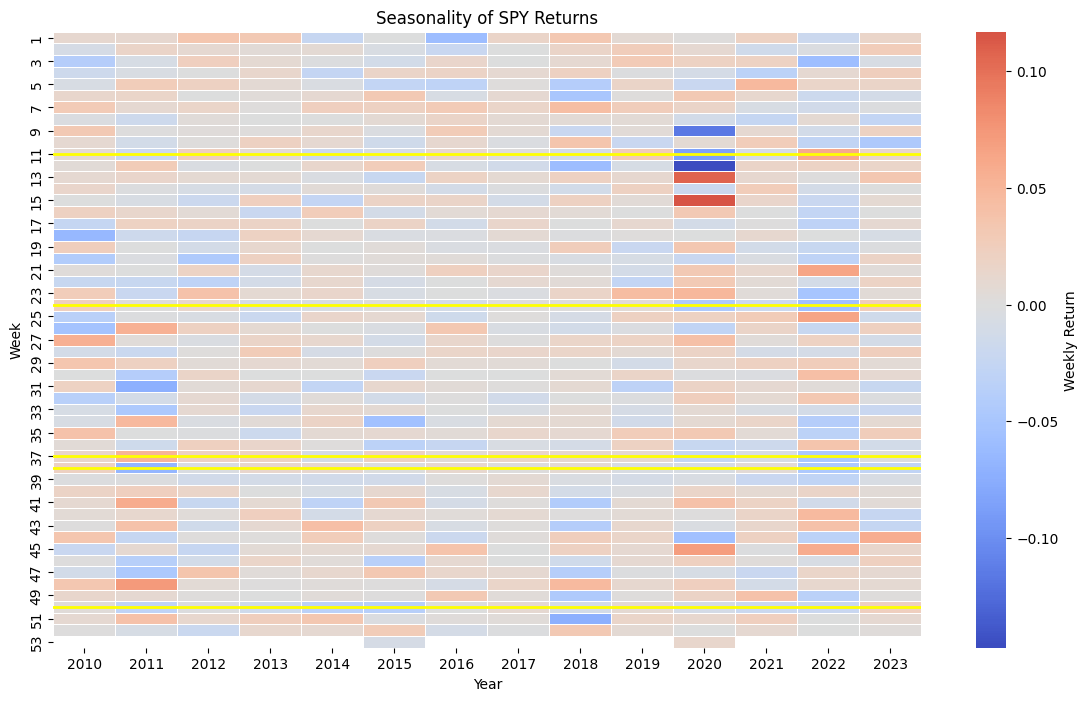

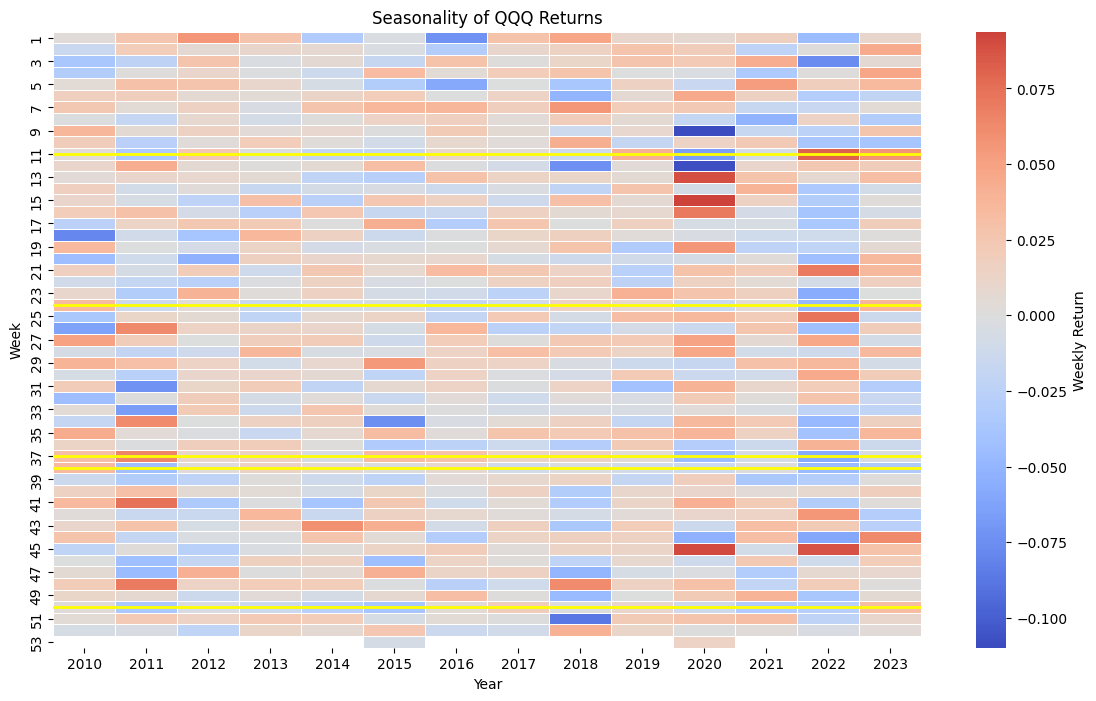

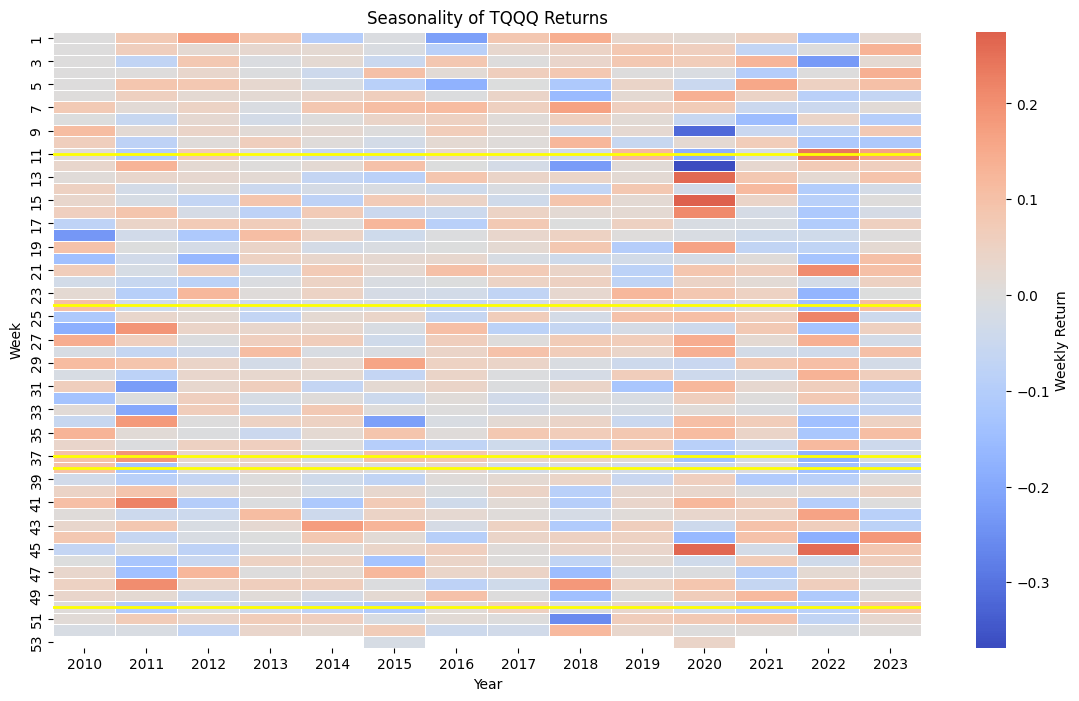

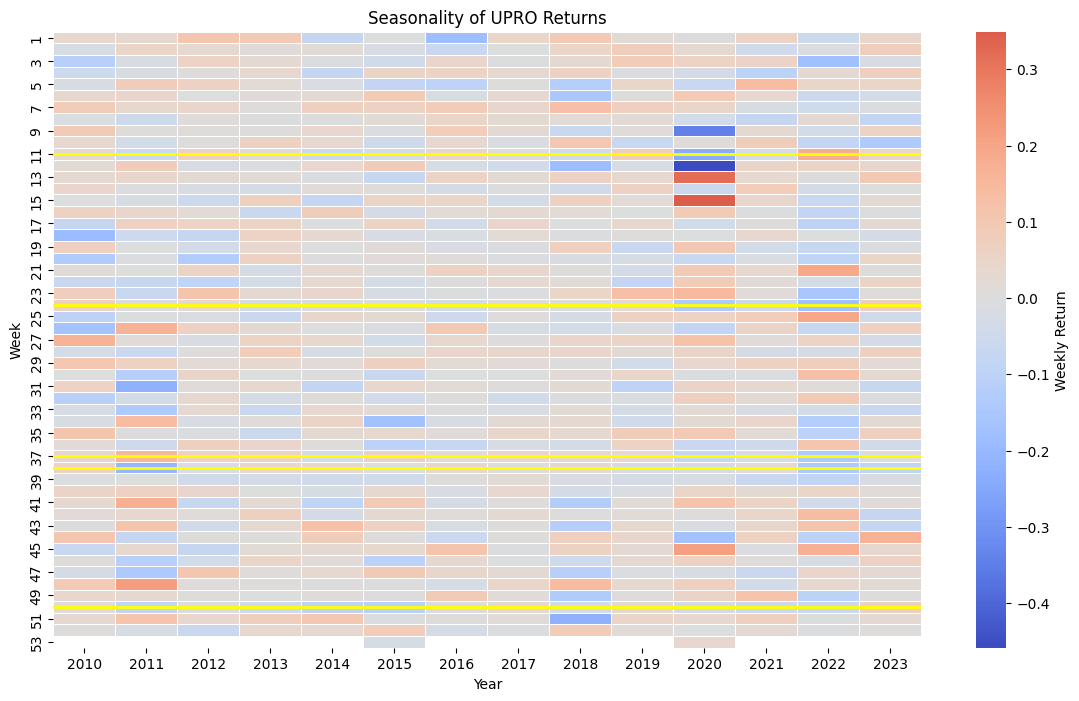

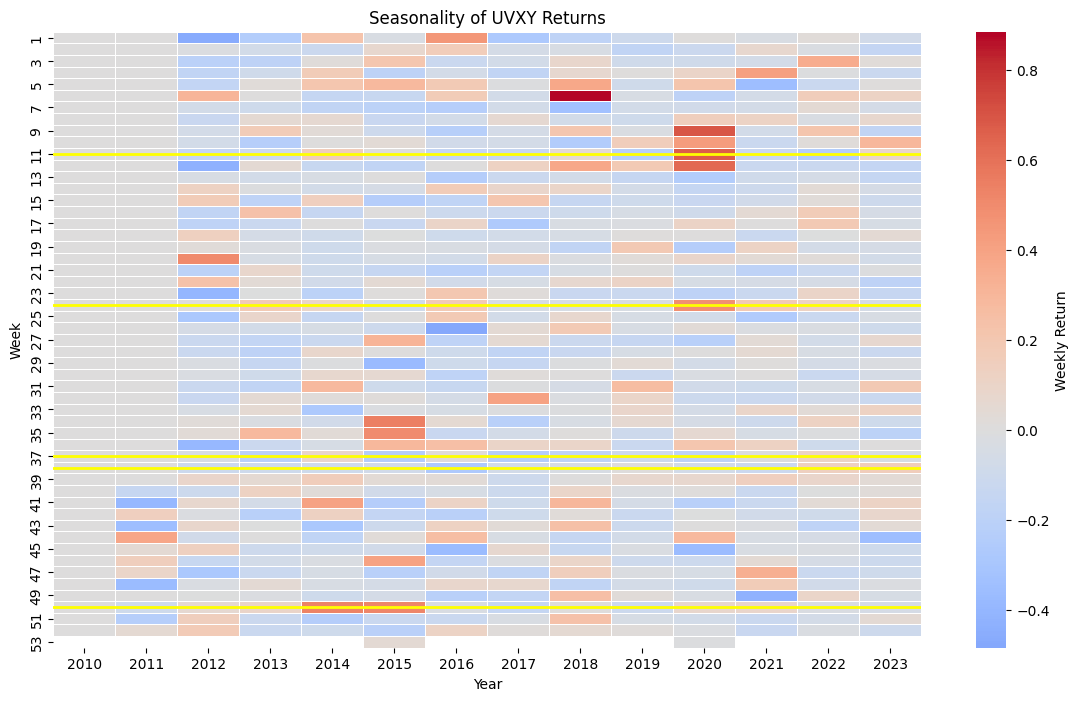

In [38]:
tickers = ["SPY", "QQQ", "TQQQ", "UPRO", "UVXY"]
triple_witching_weeks = [11, 24, 37, 38, 50]

# Visualize seasonality
visualize_weekly_seasonality(tickers, "2010-01-01", "2024-01-01", triple_witching_weeks)

# Export seasonality data to CSV
# export_weekly_seasonality_data(tickers, "2010-01-01", "2024-01-01")
